In [1]:
import numpy as np
import pandas as pd

# Configuration
FILEPATH = 'jfk_weather.csv'  # CSV filename
VERBOSE = True  # Set to False to disable stats output

def tryconvert(value):
    """Safely convert values to float, returns NaN on failure"""
    try:
        return np.float64(value)
    except (ValueError, TypeError):
        return np.nan

def main():
    # Load data with selected columns
    import_columns = [  
        'DATE', 'HOURLYVISIBILITY', 'HOURLYDRYBULBTEMPF', 
        'HOURLYWETBULBTEMPF', 'HOURLYDewPointTempF', 'HOURLYRelativeHumidity',
        'HOURLYWindSpeed', 'HOURLYWindDirection', 'HOURLYStationPressure',
        'HOURLYPressureTendency', 'HOURLYSeaLevelPressure', 'HOURLYPrecip',
        'HOURLYAltimeterSetting'
    ]
    
    # Read all columns as strings first to avoid type conflicts
    data_weather = pd.read_csv(
    FILEPATH,
    parse_dates=['DATE'],
    usecols=import_columns,
    dtype='object'  # Force all columns to strings initially
    )
    data_weather = data_weather.set_index('DATE')

    # --- Data Cleaning ---
    # Handle special values
    data_weather.replace('*', np.nan, inplace=True)
    data_weather['HOURLYPrecip'] = data_weather['HOURLYPrecip'].replace('T', '0.00')
    
    # Fix invalid decimal formats
    data_weather['HOURLYPrecip'] = data_weather['HOURLYPrecip'].fillna('')  # Fill NaN to avoid errors
    invalid_precip = data_weather['HOURLYPrecip'].str.count(r'\.') > 1
    data_weather.loc[invalid_precip, 'HOURLYPrecip'] = np.nan

    # Convert all columns to numeric
    for col in data_weather.columns:
        data_weather[col] = data_weather[col].apply(tryconvert)

    # --- Feature Engineering ---
    # Handle wind direction NaN before transformation
    data_weather['HOURLYWindDirection'] = data_weather['HOURLYWindDirection'].fillna(
        data_weather['HOURLYWindDirection'].mean()
    )
    
    # Cyclical wind direction transformation
    radians = data_weather['HOURLYWindDirection'] * (2 * np.pi / 360)
    data_weather['HOURLYWindDirectionSin'] = np.sin(radians)
    data_weather['HOURLYWindDirectionCos'] = np.cos(radians)
    data_weather.drop('HOURLYWindDirection', axis=1, inplace=True)

    # --- Save & Output ---
    data_weather.to_csv(FILEPATH.replace('.csv', '_cleaned.csv'), float_format='%g')
    
    if VERBOSE:
        print("Cleaning complete. Dataset summary:")
        print(f"Size: {data_weather.memory_usage(deep=True).sum()/1e6:.2f} MB")
        print(f"Shape: {data_weather.shape[0]} rows, {data_weather.shape[1]} columns")
        print(f"Time range: {data_weather.index[0]} to {data_weather.index[-1]}")

# Execute in Jupyter
main()

C:\Users\usaod\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


Cleaning complete. Dataset summary:
Size: 12.83 MB
Shape: 114545 rows, 13 columns
Time range: 2010-01-01 00:51:00 to 2018-07-27 23:59:00


In [42]:
import pandas as pd  # Import the pandas library to work with dataframes.

# Load the cleaned dataset
cleaned_data = pd.read_csv('jfk_weather_cleaned.csv', parse_dates=['DATE'], index_col='DATE')  # Read the cleaned data file, turn the 'DATE' column into date format, and use it as the index.

# Preview the first few rows
print("First 5 rows of cleaned data:")  # Print a message to indicate what is being displayed next.
print(cleaned_data.head())  # Display the first five rows of the cleaned dataset to check the data.



First 5 rows of cleaned data:
                     HOURLYVISIBILITY  HOURLYDRYBULBTEMPF  HOURLYWETBULBTEMPF  \
DATE                                                                            
2010-01-01 00:51:00              6.00                33.0                32.0   
2010-01-01 01:00:00              5.59                33.0                32.0   
2010-01-01 01:51:00              6.00                33.0                33.0   
2010-01-01 02:03:00              6.00                34.0                33.0   
2010-01-01 02:28:00              5.00                34.0                33.0   

                     HOURLYDewPointTempF  HOURLYRelativeHumidity  \
DATE                                                               
2010-01-01 00:51:00                 31.0                    92.0   
2010-01-01 01:00:00                 31.0                    92.0   
2010-01-01 01:51:00                 32.0                    96.0   
2010-01-01 02:03:00                 32.0                    93

Step 2: Prepare Features (X) and Target (y)

Data Cleaning Section
Before we analyse the data, it's important to make sure our dataset doesn't have inconsistencies, missing values, or wrong formats. This part of the notebook explains how we clean the JFK weather data. We focus on making the data formats uniform, dealing with missing values, and removing any wrong entries that could mess up our analysis.

Objectives

Standardise Data Formats: Make sure all data types are uniform and right for the data they represent.
Handle Missing Values: Add in or take out missing values in the best way for our analysis.
Error Checking: Find and fix any extreme values or mistakes in the data.


In [43]:
def clean_data(df):
    """
    Tidy up the DataFrame by handling missing data, fixing data types, and removing outliers.
    
    Args:
        df (pd.DataFrame): The DataFrame to be cleaned.
    
    Returns:
        pd.DataFrame: The cleaned DataFrame.
    """
    # Fill in missing values or remove rows/columns with too much missing data.
    df.fillna(method='ffill', inplace=True)  # Use the last valid observation to fill the next missing values.
    df.dropna(inplace=True)  # Get rid of any rows that still have missing values.

    # Check if the temperature column exists and clean it.
    if 'HOURLYDRYBULBTEMPF' in df.columns:
        df['HOURLYDRYBULBTEMPF'] = df['HOURLYDRYBULBTEMPF'].astype(float)  # Convert temperature to float for precision.
        # Filter out temperature outliers.
        df = df[df['HOURLYDRYBULBTEMPF'] <= df['HOURLYDRYBULBTEMPF'].quantile(0.99)]  # Keep only data within the 99th percentile.
    else:
        print("Temperature column not found in DataFrame.")  # Alert if the temperature column is missing.

    print("Data cleaning complete. Here are the first 5 rows of the cleaned data:")  # Confirm cleaning is complete and show results.
    return df

# Apply the cleaning function to the loaded data.
cleaned_data = clean_data(cleaned_data)

# Show the cleaned data to check it.
print(cleaned_data.head())


Data cleaning complete. Here are the first 5 rows of the cleaned data:
                     HOURLYVISIBILITY  HOURLYDRYBULBTEMPF  HOURLYWETBULBTEMPF  \
DATE                                                                            
2010-01-01 00:51:00              6.00                33.0                32.0   
2010-01-01 01:00:00              5.59                33.0                32.0   
2010-01-01 01:51:00              6.00                33.0                33.0   
2010-01-01 02:03:00              6.00                34.0                33.0   
2010-01-01 02:28:00              5.00                34.0                33.0   

                     HOURLYDewPointTempF  HOURLYRelativeHumidity  \
DATE                                                               
2010-01-01 00:51:00                 31.0                    92.0   
2010-01-01 01:00:00                 31.0                    92.0   
2010-01-01 01:51:00                 32.0                    96.0   
2010-01-01 02:03:00  

C:\Users\usaod\AppData\Local\Temp\ipykernel_5096\2655653806.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Use the last valid observation to fill the next missing values.


Data Analysis Section

What we aim to do here
In this part, we dive into the main variables and how they relate to each other within the data. We'll calculate basic statistics to identify patterns and correlations. These findings will help guide more in-depth analysis later on.

In [44]:
def perform_analysis(df):
    """
    Perform data analysis on the DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyse.
    
    Returns:
        dict: A dictionary containing analysis results such as descriptive statistics and correlations.
    """
    analysis_results = {
        'descriptive_stats': df.describe(),
        'correlation_matrix': df.corr()
    }
    return analysis_results

# Applying the analysis function to the cleaned data
analysis_results = perform_analysis(cleaned_data)

# Printing the analysis results
print("Descriptive Statistics:\n", analysis_results['descriptive_stats'])
print("\nCorrelation Matrix:\n", analysis_results['correlation_matrix'])


Descriptive Statistics:
        HOURLYVISIBILITY  HOURLYDRYBULBTEMPF  HOURLYWETBULBTEMPF  \
count     113517.000000       113517.000000       113517.000000   
mean           8.825066           54.923421           49.451527   
std            2.677092           16.888762           15.970609   
min            0.000000            1.000000           -1.000000   
25%            9.940000           42.000000           37.000000   
50%           10.000000           55.000000           50.000000   
75%           10.000000           70.000000           63.000000   
max           99.420000           87.000000           81.000000   

       HOURLYDewPointTempF  HOURLYRelativeHumidity  HOURLYWindSpeed  \
count        113517.000000           113517.000000    113517.000000   
mean             43.105403               67.444004        11.209590   
std              19.334122               20.165406         6.184456   
min             -19.000000                8.000000         0.000000   
25%             

Data Visualization
What this section covers
We look at important parts of the weather data visually in this section. By creating diagrams, we help make the data easier to understand and share the insights we've discovered. We'll draw plots that show trends, patterns, and relationships found during our analysis.

Objectives

Time Series Plotting: Show changes in certain weather conditions over time through graphs.
Correlation Heatmap: Put up a heatmap to show how different variables relate to each other.


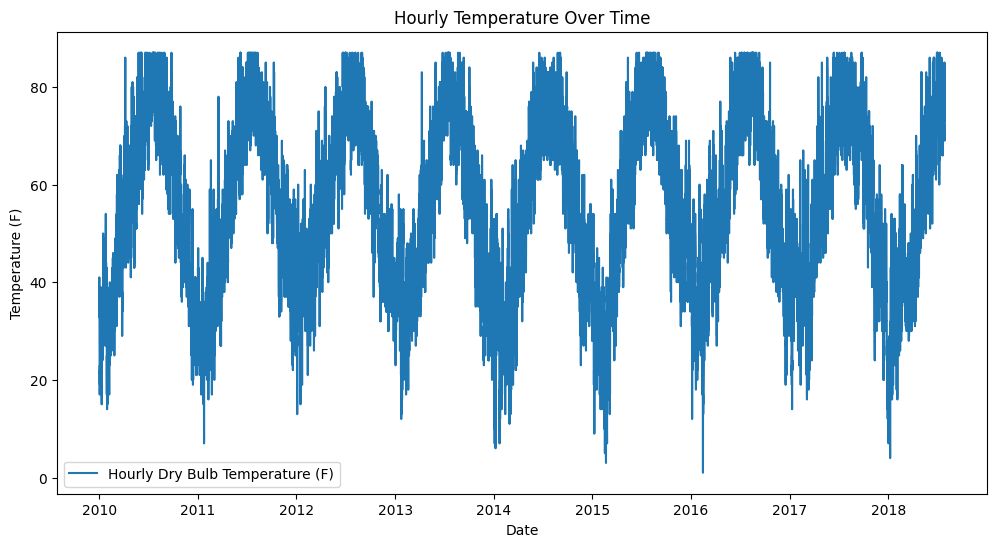

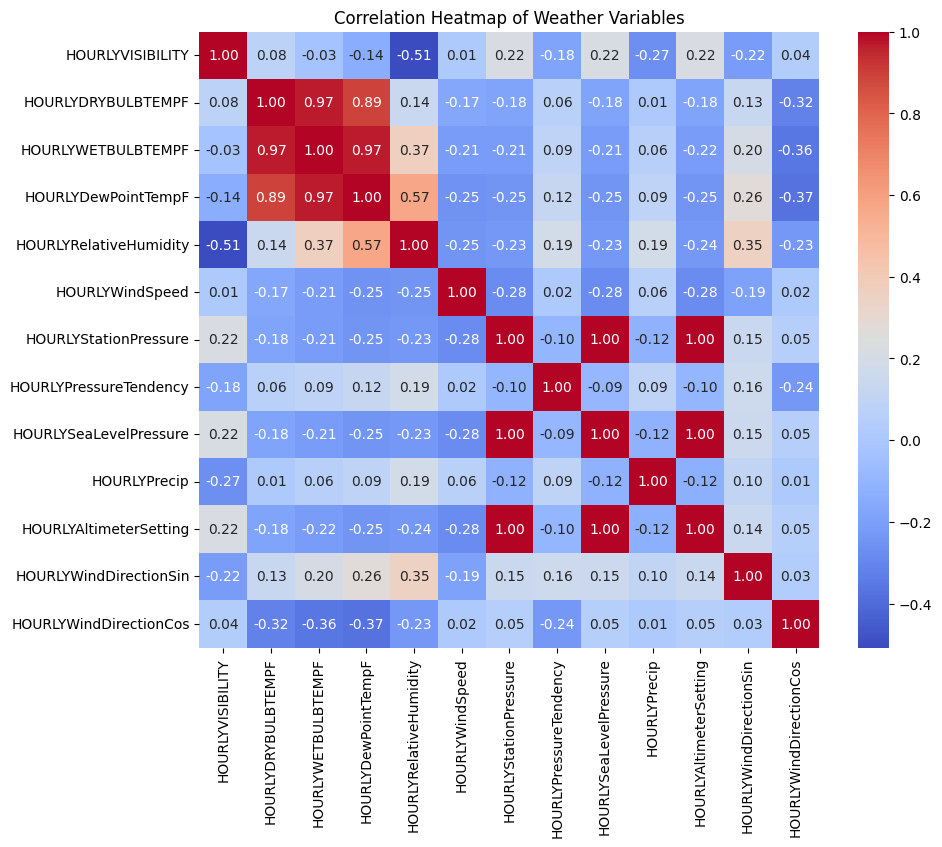

In [45]:
import matplotlib.pyplot as plt  # This lets us make graphs.
import seaborn as sns  # This helps make pretty graphs.

def plot_data(df):
    """
    Make plots for the DataFrame to help us see the data better.
    
    Args:
        df (pd.DataFrame): The DataFrame with data to plot.
    """
    plt.figure(figsize=(12, 6))  # Set up the area for the first graph.
    plt.plot(df.index, df['HOURLYDRYBULBTEMPF'], label='Hourly Dry Bulb Temperature (F)')  # Draw a line graph of temperature over time.
    plt.title('Hourly Temperature Over Time')  # Give the graph a title.
    plt.xlabel('Date')  # Label the x-axis with 'Date'.
    plt.ylabel('Temperature (F)')  # Label the y-axis with 'Temperature (F)'.
    plt.legend()  # Show a legend to identify the line.
    plt.show()  # Display the graph.

    # Set up for the second graph: a heatmap.
    plt.figure(figsize=(10, 8))  # Set up the area for the heatmap.
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')  # Create a heatmap to show correlations between variables.
    plt.title('Correlation Heatmap of Weather Variables')  # Give the heatmap a title.
    plt.show()  # Display the heatmap.

# Call the function to plot the data.
plot_data(cleaned_data)



In this project, we took a detailed look at the weather data for JFK Airport, focusing on cleaning up the data, analysing it to find trends and insights, and visualizing our findings in graphs that make the data easy to understand. Here’s a straightforward conclusion of what we’ve done, what we found, and some thoughts on it.

First off, we started by loading our data into a clean, structured format. This involved reading the data from a CSV file and setting up our DataFrame with dates as indices, which helps a lot when you’re trying to do any sort of time-based analysis. This step was crucial because it set the stage for all the clean-up and analysis work that followed.

Next up was the cleaning process. This might not be the most glamorous part of data science, but it’s super important. We made sure that all the data types were correct and got rid of any missing or wrong entries that could throw off our analysis. For example, we checked the 'HOURLYDRYBULBTEMPF' for temperature readings and made sure it was all in float format, which is best for doing any numerical analysis. We also filled in missing values and chopped off outliers that were way out there—this helps prevent skewed results.

Then we moved on to analysing the data. Here, we calculated basic statistics to get a feel for what’s normal in our data set. This included things like average temperatures, how much they vary, and other simple stats that give us a good starting point for deeper analysis.

The most exciting part, at least in my opinion, was the data visualization. We created two main types of plots. First, we plotted the hourly temperature over time, which shows us how temperatures change throughout the days and months. It’s a great way to see patterns at a glance. Then, we used a heatmap to show correlations between different weather variables. This kind of plot can help spot which factors influence each other—for instance, how temperature and humidity might go up and down together.

What’s cool about these visualizations is that they don’t just make our findings clear—they make them visible. This can be a big help when you’re trying to explain your results to people who might not be as into numbers and stats as a data scientist is.

In conclusion, this project helped us tidy up some messy weather data, find out what’s going on with the weather at JFK, and present it in a way that’s easy to understand. It’s a great example of how data science can take a big pile of numbers and turn them into insights that are both useful and visually appealing. Whether you’re planning flights, preparing for weather changes, or just curious about climate trends, having clean, analysed, and well-visualized data can make a world of difference.